
**INSTALL REQUIREMENTS**

In [0]:
if(False):
  #!pip3 install 'torch==1.3.1'
  !pip3 install 'torch==1.4.0'
  !pip3 install 'torchvision==0.5.0'
  !pip3 install 'Pillow-SIMD'
  !pip3 install 'tqdm'


**IMPORT lIBRARIES**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, random_split
from torch.backends import cudnn

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**SET ARGUMENTS**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'
#'art_painting', 'cartoon', 'photo', 'sketch'
NUM_CLASSES = 7 # ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
ALPHA = 1            # Can be anything different from None

LOG_FREQUENCY = 10

**DEFINE DATA PREPROCESSING**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.RandomCrop( 64 , padding =2) ,
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

**PREPARE DATASET**

In [0]:
# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS

Cloning into 'Homework3-PACS'...
remote: Enumerating objects: 10032, done.
remote: Total 10032 (delta 0), reused 0 (delta 0), pack-reused 10032
Receiving objects: 100% (10032/10032), 174.13 MiB | 30.12 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (9993/9993), done.


In [0]:
#TRAIN_DIR = 'Homework3-PACS/PACS/photo'
#TARGET_DIR = 'Homework3-PACS/PACS/art_painting'

DIR_art_painting = 'Homework3-PACS/PACS/art_painting'
DIR_photo = 'Homework3-PACS/PACS/photo'

# Prepare Pytorch train/test Datasets
art_painting_dataset = torchvision.datasets.ImageFolder(DIR_art_painting, transform=eval_transform)
photo_dataset = torchvision.datasets.ImageFolder(DIR_photo, transform=train_transform)

train_dataset = photo_dataset
target_dataset = art_painting_dataset

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Target Dataset: {}'.format(len(target_dataset)))

Train Dataset: 1670
Target Dataset: 2048


**PREPARE DATALOADERS**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
target_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

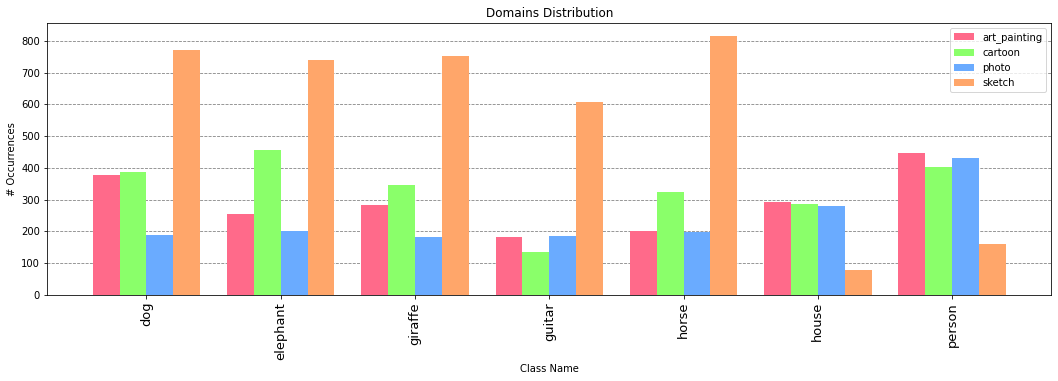

Stats for 'art_painting' domain
Total Images: 2048
Max # Images in a class: 7
Min # Images in a class: 448
Mean Images for classes: 183.00
STD Images for classes: 291.57

Stats for 'cartoon' domain
Total Images: 2344
Max # Images in a class: 7
Min # Images in a class: 456
Mean Images for classes: 134.00
STD Images for classes: 333.86

Stats for 'photo' domain
Total Images: 1670
Max # Images in a class: 7
Min # Images in a class: 431
Mean Images for classes: 181.00
STD Images for classes: 237.57

Stats for 'sketch' domain
Total Images: 3929
Max # Images in a class: 7
Min # Images in a class: 815
Mean Images for classes: 79.00
STD Images for classes: 560.29



In [0]:
#Show domains distributions
if(False):
  def getStatistics(values):
    values = list(values)
    count = len(values)
    maxv = max(values)
    minv = min(values)
    mean = np.mean(values)
    std = np.std(values)
    return [count,maxv,minv,mean,std]

  
  DIR_cartoon = 'Homework3-PACS/PACS/cartoon'
  DIR_sketch = 'Homework3-PACS/PACS/sketch'
  cartoon_dataset = torchvision.datasets.ImageFolder(DIR_cartoon, transform=train_transform)
  sketch_dataset = torchvision.datasets.ImageFolder(DIR_sketch, transform=train_transform)


  domains = ['art_painting','cartoon','photo','sketch']#classes

  datasets = [art_painting_dataset, cartoon_dataset, photo_dataset, sketch_dataset]

  art_painting_size = {}
  cartoon_size = {}
  photo_size = {}
  sketch_size = {}

  elements = [0,0,0,0,0]
  targets = train_dataset.classes + target_dataset.classes
  class_to_idx = train_dataset.class_to_idx 
  for d in datasets:
    for i in d.samples:
      elements[0] += 1
      ele_group = i[0]
      ele_class = i[1]

      
      class_name = next((name for name, index in class_to_idx.items() if index == ele_class), None)
      if(ele_group.find('art_painting')>0):
        elements[1] += 1
        if class_name not in art_painting_size:
          art_painting_size[class_name] = 0
        else:
          art_painting_size[class_name] = art_painting_size[class_name] + 1
      elif(ele_group.find('cartoon')>0):
        elements[2] += 1
        if class_name not in cartoon_size:
          cartoon_size[class_name] = 0
        else:
          cartoon_size[class_name] = cartoon_size[class_name] + 1
      elif(ele_group.find('photo')>0):
        elements[3] += 1
        if class_name not in photo_size:
          photo_size[class_name] = 0
        else:
          photo_size[class_name] = photo_size[class_name] + 1
      elif(ele_group.find('sketch')>0):
        elements[4] += 1
        if class_name not in sketch_size:
          sketch_size[class_name] = 0
        else:
          sketch_size[class_name] = sketch_size[class_name] + 1

      
  fig, ax = plt.subplots(figsize=(18,5))
  x_pos = np.arange(len(class_to_idx))
  ax.set_xticks(x_pos)
  ax.set_xticklabels(class_to_idx.keys(),rotation='vertical', fontsize=13)

  colors = ['#ff6a8a','#8aff6a','#6aabff','#ffa66a']


  width = 0.2
  ax.bar(x_pos-width*3/2, art_painting_size.values(), width=width, color=colors[0])
  ax.bar(x_pos-width/2, cartoon_size.values(), width=width, color=colors[1])
  ax.bar(x_pos+width/2, photo_size.values(), width=width, color=colors[2])
  ax.bar(x_pos+width*3/2, sketch_size.values(), width=width, color=colors[3])
  ax.set_axisbelow(True)
  ax.yaxis.grid(color='gray', linestyle='dashed')
  
  stat = {}
  stat[0] = getStatistics(art_painting_size.values())
  stat[1] = getStatistics(cartoon_size.values())
  stat[2] = getStatistics(photo_size.values())
  stat[3] = getStatistics(sketch_size.values())

  plt.title('Domains Distribution')
  plt.xlabel('Class Name')
  plt.ylabel('# Occurrences')
  plt.legend(domains)
  plt.show()

  for i in range(len(stat)):
    print("Stats for '{}' domain".format(domains[i]))
    print('Total Images: {}'.format(elements[i+1]))
    print('Max # Images in a class: {}'.format(stat[i][0]) )
    print('Min # Images in a class: {}'.format(stat[i][1]) )
    print('Mean Images for classes: {:.2f}'.format(stat[i][2]) )
    print('STD Images for classes: {:.2f}'.format(stat[i][3]) )
    print()

**PREPARE NETWORK**

In [0]:
def NumParamsToTrain(net):
  # Find total parameters and trainable parameters
  total_params = sum(p.numel() for p in net.parameters())
  print(f'{total_params:,} total parameters.')
  total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
  print(f'{total_trainable_params:,} training parameters.')
  diff = total_params-total_trainable_params
  print(f'{diff:,} freezed parameters.')
  ratio = total_trainable_params/total_params
  print(f'{ratio:.4f} ratio training/total.')

In [0]:
#####     REMEMBER TO ADD DANN.py FILE TO THE ROOT FOLDER      #####

from DANN import alexnet
def InitializeNet(freeze=False):
  net = alexnet(True) # Loading AlexNet model


  if(freeze):
    for child in net.children():
      for param in child.parameters():
        param.requires_grad = False

  # AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
  # We need 101 outputs for Caltech-101
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                  # The convolutional layer is nn.Conv2d

  #Copy wights and biases of the classifier to the domain_classifier (The two FC layers must have the same weights and biases)
  count = 0
  #These are Dropouts and ReLus which do not have weights or biases
  skip = [0,2,3,5,7]
  for i in range(len(net.classifier)):
    if(count not in skip):
      net.domain_classifier[i].weight.data = net.classifier[i].weight.data
      net.domain_classifier[i].bias.data = net.classifier[i].bias.data
    count += 1

  NumParamsToTrain(net)
  return net
net = InitializeNet()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.


**PREPARE TRAINING**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [0]:
def PlotAccuracyLoss(loss, acc, meta=''):
  
  loss_gy = loss[0]
  if(len(loss)>1):
    loss_gd = loss[1]
    loss_gd_t = loss[2]
  
  acc_gy = acc[0]
  if(len(loss)>1):
    acc_gd = acc[1]
    acc_gd_t = acc[2]

  epoch = [i for i in range(len(loss_gy))]

  fig, ax = plt.subplots(1,2,figsize=(13,7))
  size = 10

  color_gy = '#ff0000'
  color_gd = '#00a6ff'
  color_gd_t = '#51ff00'

  ax[0].plot(epoch,loss_gy,color=color_gy)
  ax[0].scatter(epoch,loss_gy,marker='s',s=size,color=color_gy)

  if(len(loss)>1):
    ax[0].plot(epoch,loss_gd,color=color_gd)
    ax[0].scatter(epoch,loss_gd,marker='s',s=size,color=color_gd)

    ax[0].plot(epoch,loss_gd_t,color=color_gd_t)
    ax[0].scatter(epoch,loss_gd_t,marker='s',s=size,color=color_gd_t)

  ax[0].set_title('Loss Graph')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  

  ax[1].plot(epoch,acc_gy,color=color_gy)
  ax[1].scatter(epoch,acc_gy,marker='s',s=size,color=color_gy)

  if(len(loss)>1):
    ax[1].plot(epoch,acc_gd,color=color_gd)
    ax[1].scatter(epoch,acc_gd,marker='s',s=size,color=color_gd)

    ax[1].plot(epoch,acc_gd_t,color=color_gd_t)
    ax[1].scatter(epoch,acc_gd_t,marker='s',s=size,color=color_gd_t)

  ax[1].set_title('Accurancy Graph')
  ax[1].set_ylabel('Accurancy')
  ax[1].set_xlabel('Epoch')
  
  fig.suptitle(meta)
  if(len(loss)>1):
    plt.legend(["Classifier",'Domain Classifier','Domain Classifier(Target)'])
  else:
    plt.legend(["Classifier"])

  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

  print('Classifier: Min Loss: {:.6f}, Max Acc: {:.6f}'.format( min(loss_gy),max(acc_gy) ))
  if(len(loss)>1):
    print('Domain Classifier: Min Loss: {:.6f}, Max Acc: {:.6f}'.format( min(loss_gd),max(acc_gd) ))
    print('Domain Classifier(Target): Min Loss: {:.6f}, Max Acc: {:.6f}'.format( min(loss_gd_t),max(acc_gd_t) ))

TRAINING WITHOUT ADAPTATION

In [0]:
PATH_MODELS = 'Models/'
if not os.path.isdir('./'+PATH_MODELS):
  os.mkdir('./'+PATH_MODELS)
def Training(net, adaptation=None, meta=''):
  # By default, everything is loaded to cpu
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  best_acc = -99
  #best_net = None

  current_step = 0
  losses_gy = []
  if(adaptation):
    losses_gd = []
    losses_gd_t = []

  accuracies_gy = []
  if(adaptation):
    accuracies_gd = []
    accuracies_gd_t = []

  # Start iterating over the epochs
  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

    running_corrects_gy = 0
    if(adaptation):
      running_corrects_gd = 0
      running_corrects_gd_t = 0

    # Iterate over the dataset
    for i, (images, labels) in enumerate(train_dataloader):
      # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)


      if(adaptation):
        target_images, _ = SampleTarget(current_step)
        target_images = target_images.to(DEVICE)

      net.train() # Sets module in training mode

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      max_loss = 6.0

      #####   STEP 1/3  #####
      #####   Forward to Gy and back propagate  #####
      # Forward pass to the network Gy
      outputs_gy = net(images)
      # Compute loss based on output and ground truth
      loss_gy = criterion(outputs_gy, labels)
      loss_gy.backward()  # backward pass: computes gradients
      loss_gy_value = loss_gy.item() if loss_gy.item() < max_loss else max_loss


      if(adaptation):
        #####   STEP 2/3  #####
        #####   Forward to Gd and back propagate  #####
        # Forward pass to the network Gd
        outputs_gd = net(images,ALPHA)
        #labels are 0 for all the data
        labels_gd = torch.tensor([0] * BATCH_SIZE)
        labels_gd = labels_gd.to(DEVICE)
        loss_gd = criterion(outputs_gd, labels_gd)
        loss_gd.backward()  # backward pass: computes
        loss_gd_value = loss_gd.item() if loss_gd.item() < max_loss else max_loss

        #####   STEP 3/3  #####
        #####   Forward to Gd and back propagate  #####
        # Forward pass to the network Gd
        outputs_gd_t = net(target_images,ALPHA)
        #labels are 1 for all the data
        labels_gd_t = torch.tensor([1] * BATCH_SIZE)#
        labels_gd_t = labels_gd_t.to(DEVICE)
        loss_gd_t = criterion(outputs_gd_t, labels_gd_t)
        loss_gd_t.backward()  # backward pass: computes
        loss_gd_t_value = loss_gd_t.item() if loss_gd_t.item() < max_loss else max_loss
      

      # Get predictions
      _, preds_gy = torch.max(outputs_gy.data, 1)

      if(adaptation):
        _, preds_gd = torch.max(outputs_gd.data, 1)
        _, preds_gd_t = torch.max(outputs_gd_t.data, 1)
        
      # Update Corrects
      running_corrects_gy += torch.sum(preds_gy == labels.data).data.item()
      if(adaptation):
        running_corrects_gd += torch.sum(preds_gd == labels_gd.data).data.item()
        running_corrects_gd_t += torch.sum(preds_gd_t == labels_gd_t.data).data.item()

      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        if(adaptation):
          print('Step {}, Loss Classifier: {:.4}, Domain Classifier: {:.4}, Domain Classifier(Target): {:.4}'.format(current_step, loss_gy_value, loss_gd, loss_gd_t))
        else:
          print('Step {}, Loss Classifier: {:.4}'.format(current_step, loss_gy_value))

      # Compute gradients for each layer and update weights
      
      optimizer.step() # update weights based on accumulated gradients

      current_step += 1

      # Step the scheduler
      #scheduler.step() 
    
    # Calculate Accuracy
    accuracy_gy = running_corrects_gy / float(len(train_dataset))

    if(adaptation):
      accuracy_gd = running_corrects_gd / float(len(train_dataset))
      accuracy_gd_t = running_corrects_gd_t / float(len(target_dataset))

    if(accuracy_gy>best_acc):
      best_acc = accuracy_gy
      torch.save(net, PATH_MODELS+meta+'.pth')
      #best_model=net

    losses_gy.append(loss_gy_value)

    if(adaptation):
      losses_gd.append(loss_gd_value)
      losses_gd_t.append(loss_gd_t_value)

    accuracies_gy.append(accuracy_gy)

    if(adaptation):
      accuracies_gd.append(accuracy_gd)
      accuracies_gd_t.append(accuracy_gd_t)

    # Step the scheduler
    scheduler.step() 


  if(adaptation):
    losses = [losses_gy,losses_gd,losses_gd_t]
    accuracies = [accuracies_gy,accuracies_gd,accuracies_gd_t]
  else:
    losses = [losses_gy]
    accuracies = [accuracies_gy]
    
  return losses, accuracies

In [0]:
def Test(net):
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in (target_dataloader):#tqdm
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(target_dataset))

  print('Test Accuracy: {}'.format(accuracy))

Starting epoch 1/30, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss Classifier: 2.79
Starting epoch 2/30, LR = [0.001]
Step 10, Loss Classifier: 0.9478
Starting epoch 3/30, LR = [0.001]
Starting epoch 4/30, LR = [0.001]
Step 20, Loss Classifier: 0.7905
Starting epoch 5/30, LR = [0.001]
Starting epoch 6/30, LR = [0.001]
Step 30, Loss Classifier: 0.73
Starting epoch 7/30, LR = [0.001]
Step 40, Loss Classifier: 0.7635
Starting epoch 8/30, LR = [0.001]
Starting epoch 9/30, LR = [0.001]
Step 50, Loss Classifier: 0.7363
Starting epoch 10/30, LR = [0.001]
Starting epoch 11/30, LR = [0.001]
Step 60, Loss Classifier: 0.7317
Starting epoch 12/30, LR = [0.001]
Step 70, Loss Classifier: 0.5918
Starting epoch 13/30, LR = [0.001]
Starting epoch 14/30, LR = [0.001]
Step 80, Loss Classifier: 0.7359
Starting epoch 15/30, LR = [0.001]
Starting epoch 16/30, LR = [0.001]
Step 90, Loss Classifier: 0.6343
Starting epoch 17/30, LR = [0.001]
Step 100, Loss Classifier: 0.6494
Starting epoch 18/30, LR = [0.001]
Starting epoch 19/30, LR = [0.001]
Step 110, Loss Clas

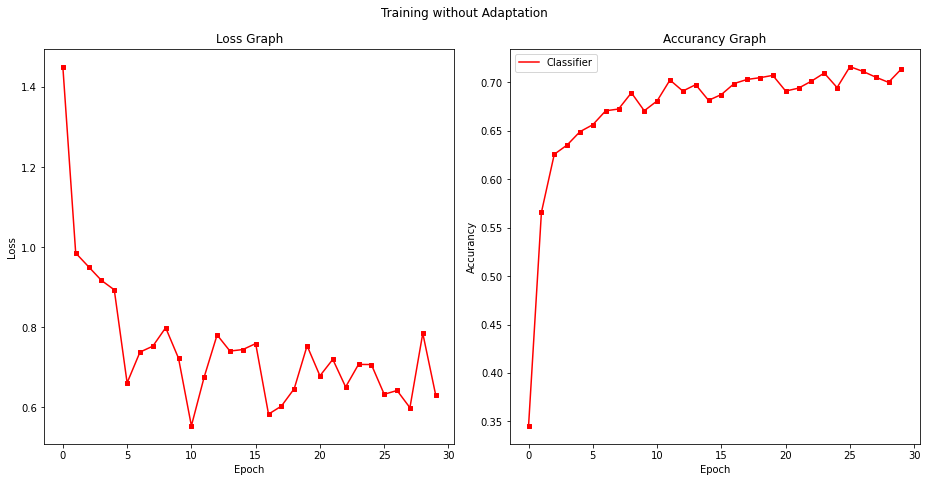

Classifier: Min Loss: 0.553737, Max Acc: 0.716168

Test Accuracy: 0.45263671875


In [0]:
if(False):
  meta_t = 'noAdap'
  losses, accuracies = Training(net,meta=meta_t)

  print()
  meta = 'Training without Adaptation'
  PlotAccuracyLoss(losses,accuracies,meta)

  print()
  best_net = torch.load(PATH_MODELS+meta_t+'.pth')
  Test(best_net)

TRAINING WITH ADAPTATION

In [0]:
net = InitializeNet()

#Set alpha as you like (must be a float!)
net.setAlpha(nn.Parameter(torch.tensor(0.1)))

criterion = nn.CrossEntropyLoss()

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.


In [0]:
n_batches = len(target_dataset)//BATCH_SIZE
target_set = iter(target_dataloader)

def SampleTarget(step):
  global target_set
  if step % n_batches == 0:
    target_set = iter(target_dataloader)
  return target_set.__next__()

Starting epoch 1/30, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss Classifier: 2.854, Domain Classifier: 2.645, Domain Classifier(Target): 2.646
Starting epoch 2/30, LR = [0.001]
Step 10, Loss Classifier: 0.9784, Domain Classifier: 0.283, Domain Classifier(Target): 0.01902
Starting epoch 3/30, LR = [0.001]
Starting epoch 4/30, LR = [0.001]
Step 20, Loss Classifier: 0.9255, Domain Classifier: 0.00985, Domain Classifier(Target): 0.1743
Starting epoch 5/30, LR = [0.001]
Starting epoch 6/30, LR = [0.001]
Step 30, Loss Classifier: 0.9079, Domain Classifier: 0.08183, Domain Classifier(Target): 0.1237
Starting epoch 7/30, LR = [0.001]
Step 40, Loss Classifier: 0.9266, Domain Classifier: 0.05439, Domain Classifier(Target): 0.05383
Starting epoch 8/30, LR = [0.001]
Starting epoch 9/30, LR = [0.001]
Step 50, Loss Classifier: 0.7734, Domain Classifier: 0.1221, Domain Classifier(Target): 0.06523
Starting epoch 10/30, LR = [0.001]
Starting epoch 11/30, LR = [0.001]
Step 60, Loss Classifier: 0.6514, Domain Classifier: 0.06934, Domain Classifier(Target)

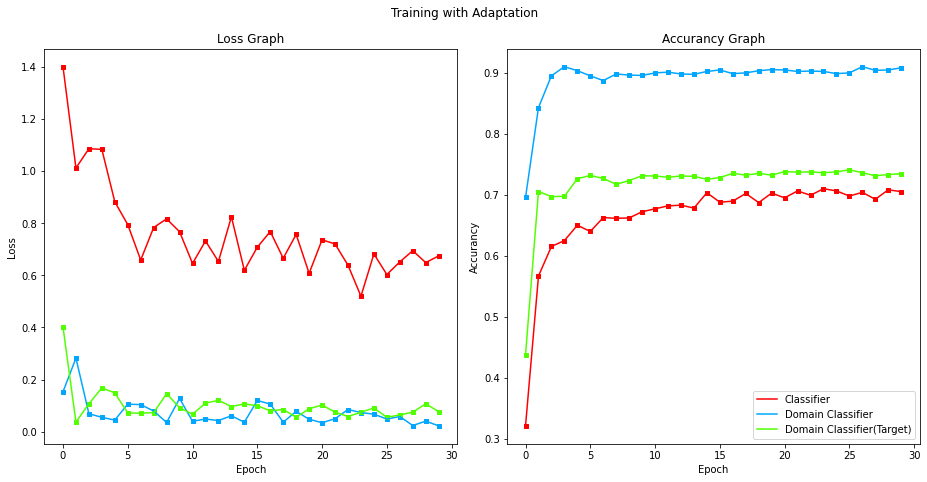

Classifier: Min Loss: 0.519971, Max Acc: 0.710180
Domain Classifier: Min Loss: 0.023147, Max Acc: 0.910180
Domain Classifier(Target): Min Loss: 0.037678, Max Acc: 0.741211

Test Accuracy: 0.46533203125


In [0]:
if(False):
  meta_t = 'Adap'
  losses, accuracies = Training(net,True,meta=meta_t)

  print()
  meta = 'Training with Adaptation'
  PlotAccuracyLoss(losses,accuracies,meta)

  print()
  best_net = torch.load(PATH_MODELS+meta_t+'.pth')
  Test(best_net)

**(EXTRA) HYPERPARAMETER OPTIMIZATION**

In [0]:
def GetMaxAcc(scores):
  values = dict()
  for k,v in scores.items():
    values[k] = []
    acc = (0,0,0)

    a=np.array(v[1])
    if(len(a)==3):
      acc = ( np.max(a[0]), np.max(a[1]), np.max(a[2]) )
    else:
      acc = (np.max(a), -1, -1)
    values[k].append(acc)

  return values

def SketchHeatMap(scores,trainAcc=False):
  score = GetMaxAcc(scores)

  keys = list(score.keys())
  rows = sorted(set(i[0] for i in keys),reverse=True)
  cols = sorted(set(i[1] for i in keys))

  meta = 'Training'

  values = []
  for v in list(score.values()):
    for i in v:
      values.append(i[0]) 

  v = np.reshape(values,(3,3))

  pd_scores = pd.DataFrame(v, index=rows, columns=cols)
  sns.heatmap(pd_scores, vmin=0, vmax=1, linewidths=.1, annot=True,xticklabels='auto', yticklabels='auto')
  plt.xlabel("Optimizer")
  plt.ylabel("Learning Rate")
  plt.title('HeatMap {} Accuracy'.format(meta))
  plt.show()

NO ADAPTATION

---  Training with LR = 0.01 and Optimazer = Adam  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/25, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss Classifier: 2.805
Starting epoch 2/25, LR = [0.01]
Step 10, Loss Classifier: 6.0
Starting epoch 3/25, LR = [0.01]
Starting epoch 4/25, LR = [0.01]
Step 20, Loss Classifier: 6.0
Starting epoch 5/25, LR = [0.01]
Starting epoch 6/25, LR = [0.01]
Step 30, Loss Classifier: 6.0
Starting epoch 7/25, LR = [0.01]
Step 40, Loss Classifier: 1.925
Starting epoch 8/25, LR = [0.01]
Starting epoch 9/25, LR = [0.01]
Step 50, Loss Classifier: 1.952
Starting epoch 10/25, LR = [0.01]
Starting epoch 11/25, LR = [0.01]
Step 60, Loss Classifier: 1.904
Starting epoch 12/25, LR = [0.01]
Step 70, Loss Classifier: 1.887
Starting epoch 13/25, LR = [0.01]
Starting epoch 14/25, LR = [0.01]
Step 80, Loss Classifier: 1.875
Starting epoch 15/25, LR = [0.01]
Starting epoch 16/25, LR = [0.01]
Step 90, Loss Classifier: 1.909
Starting epoch 17/25, LR = [0.01]
Step 100, Loss Classifier: 2.77
Starting epoch 18/25, LR = [0.01]
Starting epoch 19/25, LR = [0.01]
Step 110, Loss Classifier: 1.894
Starting epoch 20/

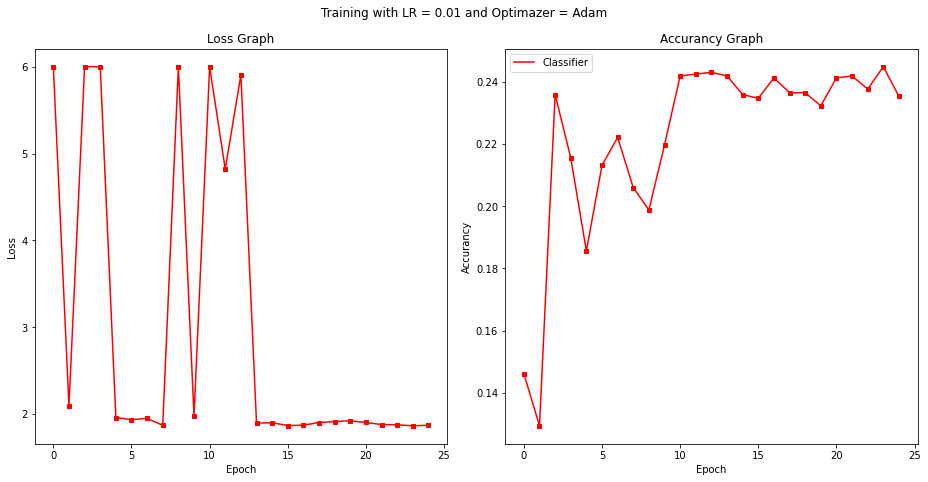

Classifier: Min Loss: 1.864800, Max Acc: 0.244910
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = RMSprop  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/25, LR = [0.01]
Step 0, Loss Classifier: 2.447
Starting epoch 2/25, LR = [0.01]
Step 10, Loss Classifier: 6.0
Starting epoch 3/25, LR = [0.01]
Starting epoch 4/25, LR = [0.01]
Step 20, Loss Classifier: 6.0
Starting epoch 5/25, LR = [0.01]
Starting epoch 6/25, LR = [0.01]
Step 30, Loss Classifier: 6.0
Starting epoch 7/25, LR = [0.01]
Step 40, Loss Classifier: 6.0
Starting epoch 8/25, LR = [0.01]
Starting epoch 9/25, LR = [0.01]
Step 50, Loss Classifier: 6.0
Starting epoch 10/25, LR = [0.01]
Starting epoch 11/25, LR = [0.01]
Step 60, Loss Classifier: 6.0
Starting epoch 12/25, LR = [0.01]
Step 70, Loss Classifier: 6.0
Starting epoch 13/25, LR = [0.01]
Starting epoch 14/25, LR = [0.01]
Step 80, Loss Classifier: 6.0
Starting epoch 15/25

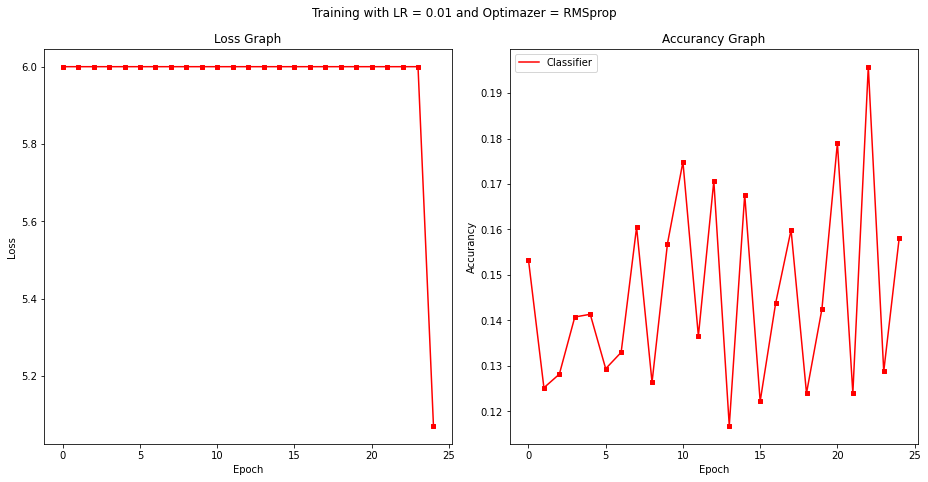

Classifier: Min Loss: 5.070456, Max Acc: 0.195808
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = SGD  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/25, LR = [0.01]
Step 0, Loss Classifier: 2.292
Starting epoch 2/25, LR = [0.01]
Step 10, Loss Classifier: 1.141
Starting epoch 3/25, LR = [0.01]
Starting epoch 4/25, LR = [0.01]
Step 20, Loss Classifier: 0.9583
Starting epoch 5/25, LR = [0.01]
Starting epoch 6/25, LR = [0.01]
Step 30, Loss Classifier: 0.9186
Starting epoch 7/25, LR = [0.01]
Step 40, Loss Classifier: 0.764
Starting epoch 8/25, LR = [0.01]
Starting epoch 9/25, LR = [0.01]
Step 50, Loss Classifier: 0.7468
Starting epoch 10/25, LR = [0.01]
Starting epoch 11/25, LR = [0.01]
Step 60, Loss Classifier: 0.6117
Starting epoch 12/25, LR = [0.01]
Step 70, Loss Classifier: 0.7283
Starting epoch 13/25, LR = [0.01]
Starting epoch 14/25, LR = [0.01]
Step 80, Loss Classifier: 0.7041
St

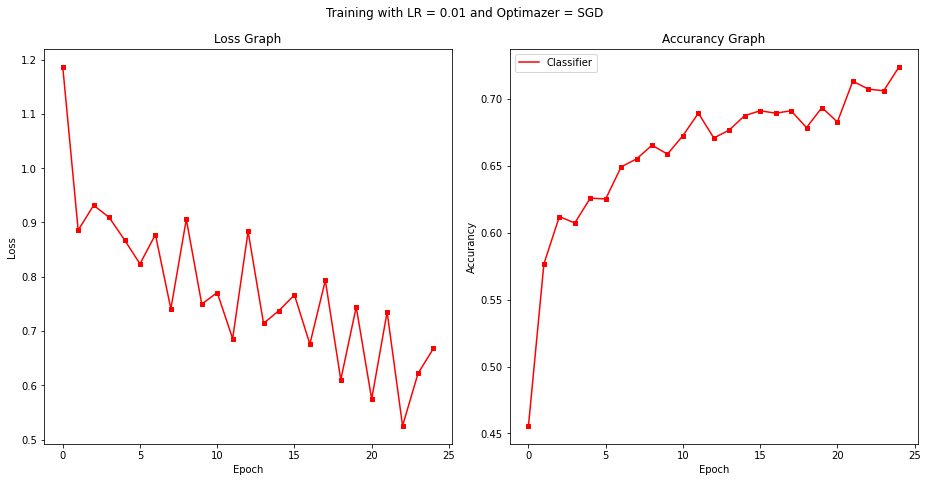

Classifier: Min Loss: 0.525201, Max Acc: 0.723952
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = Adam  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/25, LR = [0.001]
Step 0, Loss Classifier: 2.449
Starting epoch 2/25, LR = [0.001]
Step 10, Loss Classifier: 1.839
Starting epoch 3/25, LR = [0.001]
Starting epoch 4/25, LR = [0.001]
Step 20, Loss Classifier: 1.514
Starting epoch 5/25, LR = [0.001]
Starting epoch 6/25, LR = [0.001]
Step 30, Loss Classifier: 1.258
Starting epoch 7/25, LR = [0.001]
Step 40, Loss Classifier: 1.354
Starting epoch 8/25, LR = [0.001]
Starting epoch 9/25, LR = [0.001]
Step 50, Loss Classifier: 1.257
Starting epoch 10/25, LR = [0.001]
Starting epoch 11/25, LR = [0.001]
Step 60, Loss Classifier: 1.283
Starting epoch 12/25, LR = [0.001]
Step 70, Loss Classifier: 1.257
Starting epoch 13/25, LR = [0.001]
Starting epoch 14/25, LR = [0.001]
Step 80, Loss Classifier

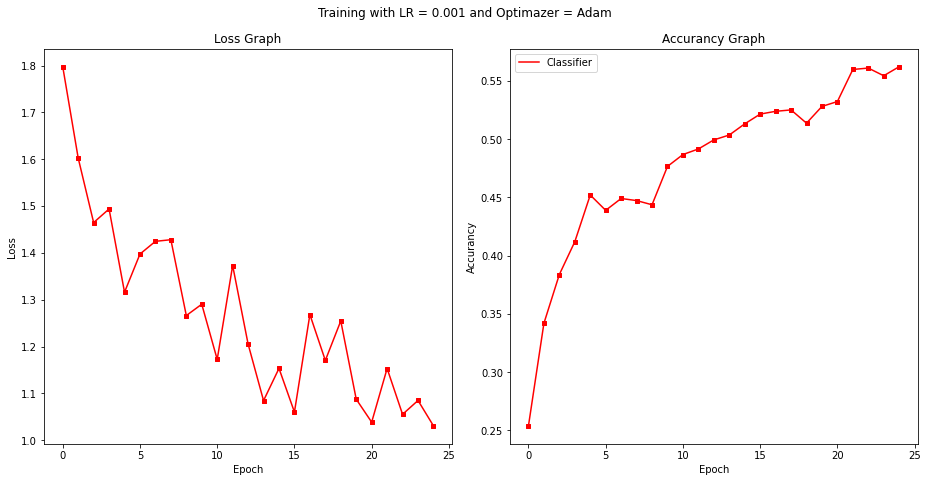

Classifier: Min Loss: 1.030565, Max Acc: 0.562275
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = RMSprop  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/25, LR = [0.001]
Step 0, Loss Classifier: 2.779
Starting epoch 2/25, LR = [0.001]
Step 10, Loss Classifier: 6.0
Starting epoch 3/25, LR = [0.001]
Starting epoch 4/25, LR = [0.001]
Step 20, Loss Classifier: 6.0
Starting epoch 5/25, LR = [0.001]
Starting epoch 6/25, LR = [0.001]
Step 30, Loss Classifier: 2.166
Starting epoch 7/25, LR = [0.001]
Step 40, Loss Classifier: 1.965
Starting epoch 8/25, LR = [0.001]
Starting epoch 9/25, LR = [0.001]
Step 50, Loss Classifier: 1.927
Starting epoch 10/25, LR = [0.001]
Starting epoch 11/25, LR = [0.001]
Step 60, Loss Classifier: 1.879
Starting epoch 12/25, LR = [0.001]
Step 70, Loss Classifier: 1.943
Starting epoch 13/25, LR = [0.001]
Starting epoch 14/25, LR = [0.001]
Step 80, Loss Classifier:

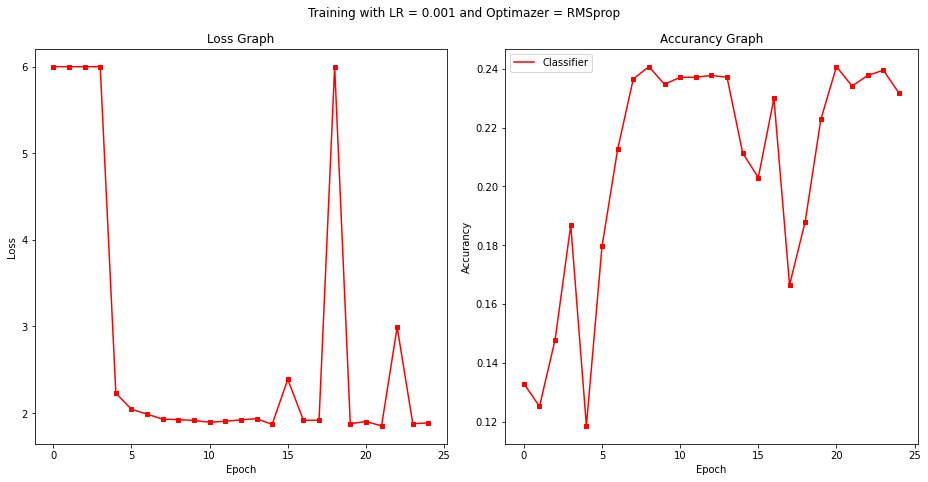

Classifier: Min Loss: 1.852877, Max Acc: 0.240719
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = SGD  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/25, LR = [0.001]
Step 0, Loss Classifier: 3.204
Starting epoch 2/25, LR = [0.001]
Step 10, Loss Classifier: 1.133
Starting epoch 3/25, LR = [0.001]
Starting epoch 4/25, LR = [0.001]
Step 20, Loss Classifier: 0.9199
Starting epoch 5/25, LR = [0.001]
Starting epoch 6/25, LR = [0.001]
Step 30, Loss Classifier: 0.7722
Starting epoch 7/25, LR = [0.001]
Step 40, Loss Classifier: 0.6431
Starting epoch 8/25, LR = [0.001]
Starting epoch 9/25, LR = [0.001]
Step 50, Loss Classifier: 0.729
Starting epoch 10/25, LR = [0.001]
Starting epoch 11/25, LR = [0.001]
Step 60, Loss Classifier: 0.5945
Starting epoch 12/25, LR = [0.001]
Step 70, Loss Classifier: 0.6905
Starting epoch 13/25, LR = [0.001]
Starting epoch 14/25, LR = [0.001]
Step 80, Loss Classi

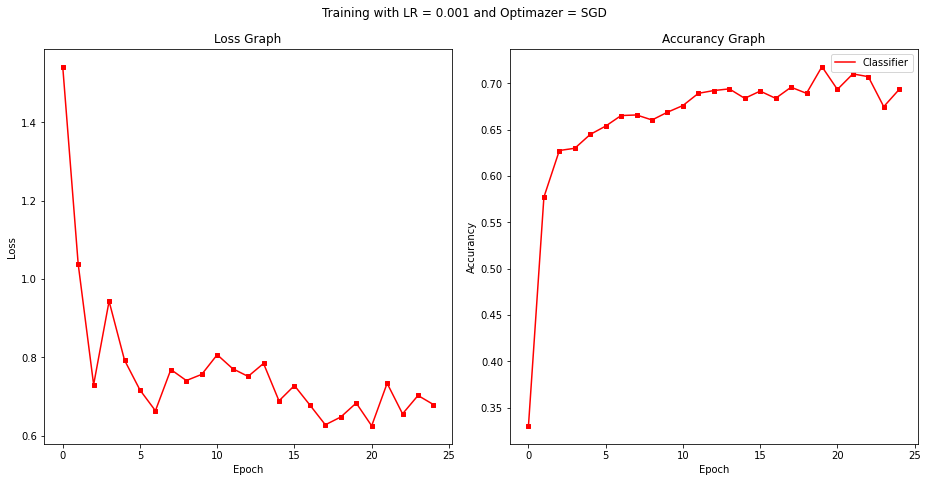

Classifier: Min Loss: 0.625139, Max Acc: 0.717964
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = Adam  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/25, LR = [1e-05]
Step 0, Loss Classifier: 3.032
Starting epoch 2/25, LR = [1e-05]
Step 10, Loss Classifier: 1.939
Starting epoch 3/25, LR = [1e-05]
Starting epoch 4/25, LR = [1e-05]
Step 20, Loss Classifier: 1.519
Starting epoch 5/25, LR = [1e-05]
Starting epoch 6/25, LR = [1e-05]
Step 30, Loss Classifier: 1.253
Starting epoch 7/25, LR = [1e-05]
Step 40, Loss Classifier: 1.075
Starting epoch 8/25, LR = [1e-05]
Starting epoch 9/25, LR = [1e-05]
Step 50, Loss Classifier: 1.078
Starting epoch 10/25, LR = [1e-05]
Starting epoch 11/25, LR = [1e-05]
Step 60, Loss Classifier: 1.039
Starting epoch 12/25, LR = [1e-05]
Step 70, Loss Classifier: 0.986
Starting epoch 13/25, LR = [1e-05]
Starting epoch 14/25, LR = [1e-05]
Step 80, Loss Classifier

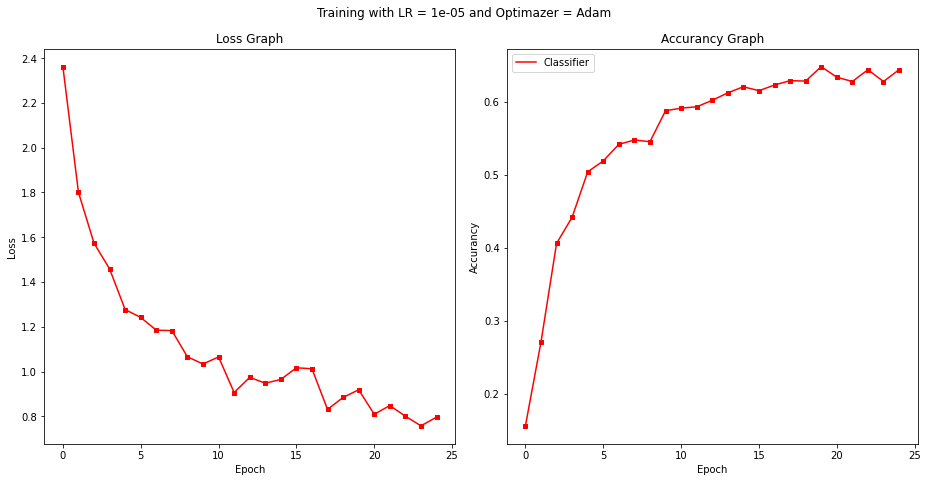

Classifier: Min Loss: 0.757779, Max Acc: 0.648503
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = RMSprop  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/25, LR = [1e-05]
Step 0, Loss Classifier: 2.494
Starting epoch 2/25, LR = [1e-05]
Step 10, Loss Classifier: 0.9539
Starting epoch 3/25, LR = [1e-05]
Starting epoch 4/25, LR = [1e-05]
Step 20, Loss Classifier: 0.7367
Starting epoch 5/25, LR = [1e-05]
Starting epoch 6/25, LR = [1e-05]
Step 30, Loss Classifier: 0.8799
Starting epoch 7/25, LR = [1e-05]
Step 40, Loss Classifier: 0.7321
Starting epoch 8/25, LR = [1e-05]
Starting epoch 9/25, LR = [1e-05]
Step 50, Loss Classifier: 0.7594
Starting epoch 10/25, LR = [1e-05]
Starting epoch 11/25, LR = [1e-05]
Step 60, Loss Classifier: 0.6395
Starting epoch 12/25, LR = [1e-05]
Step 70, Loss Classifier: 0.6452
Starting epoch 13/25, LR = [1e-05]
Starting epoch 14/25, LR = [1e-05]
Step 80, Loss 

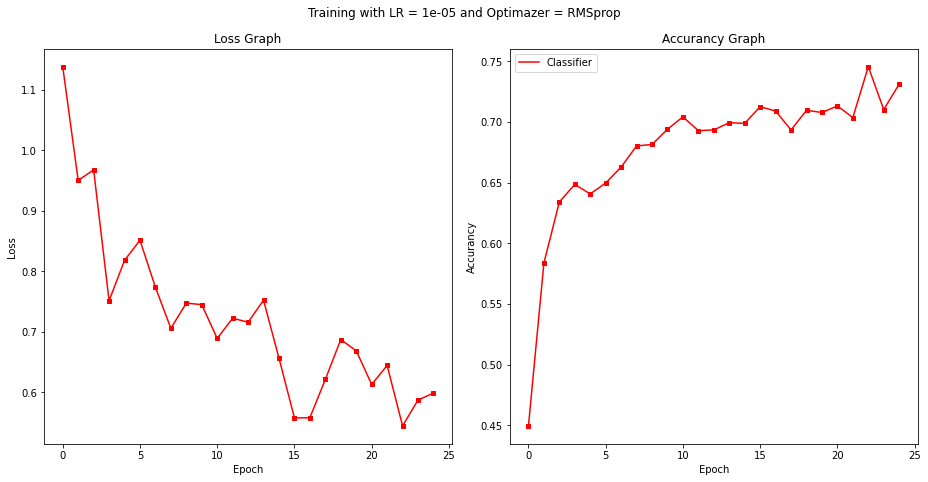

Classifier: Min Loss: 0.544705, Max Acc: 0.745509
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = SGD  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/25, LR = [1e-05]
Step 0, Loss Classifier: 2.868
Starting epoch 2/25, LR = [1e-05]
Step 10, Loss Classifier: 2.547
Starting epoch 3/25, LR = [1e-05]
Starting epoch 4/25, LR = [1e-05]
Step 20, Loss Classifier: 2.132
Starting epoch 5/25, LR = [1e-05]
Starting epoch 6/25, LR = [1e-05]
Step 30, Loss Classifier: 2.047
Starting epoch 7/25, LR = [1e-05]
Step 40, Loss Classifier: 1.998
Starting epoch 8/25, LR = [1e-05]
Starting epoch 9/25, LR = [1e-05]
Step 50, Loss Classifier: 1.796
Starting epoch 10/25, LR = [1e-05]
Starting epoch 11/25, LR = [1e-05]
Step 60, Loss Classifier: 1.601
Starting epoch 12/25, LR = [1e-05]
Step 70, Loss Classifier: 1.678
Starting epoch 13/25, LR = [1e-05]
Starting epoch 14/25, LR = [1e-05]
Step 80, Loss Classifier:

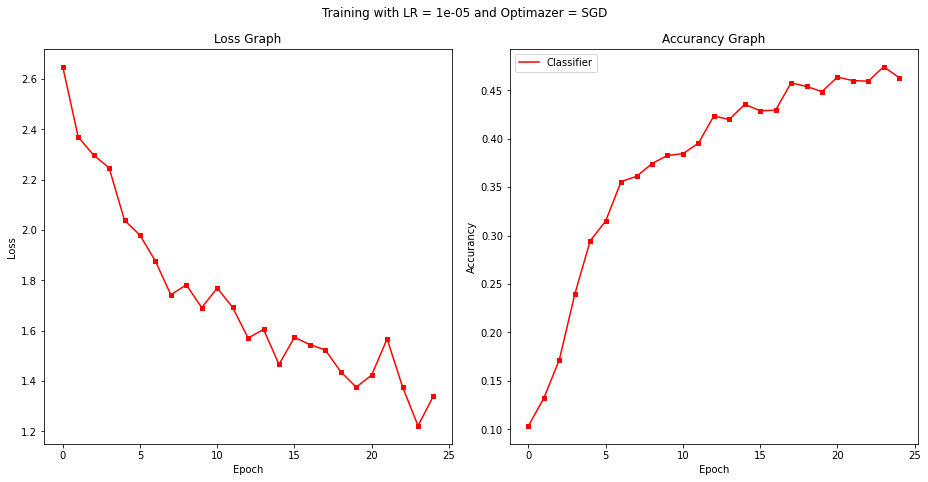

Classifier: Min Loss: 1.222192, Max Acc: 0.474251
---  --- ---  ---



In [0]:
NUM_EPOCHS = 25
lr_values = [0.01, 0.001, 0.00001]
optimazers = ['Adam','RMSprop','SGD']

scores_noAdap = {}
for lr in lr_values:
  for op in optimazers:

    meta = 'Training with LR = {} and Optimazer = {}'.format(lr,op)
    print('---  {}  ---'.format(meta))

    net = InitializeNet()
    print()

    criterion = nn.CrossEntropyLoss()

    parameters_to_optimize = net.parameters()
    if(op == 'Adam'):
      optimizer = optim.Adam(parameters_to_optimize, lr=lr, weight_decay=WEIGHT_DECAY)
    elif(op == 'RMSprop'):
      optimizer = optim.RMSprop(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    else:
      optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    meta_t = 'noAdap lr={}, op={}'.format(lr,op)
    losses, accuracies = Training(net,meta=meta_t)
    PlotAccuracyLoss(losses,accuracies,meta)

    scores_noAdap[(lr,op)] = (losses, accuracies)

    print('---  --- ---  ---')
    print()


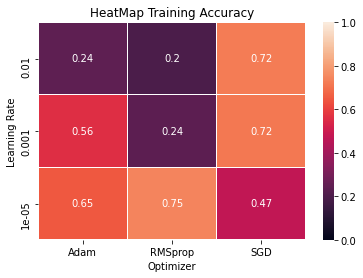

In [0]:
SketchHeatMap(scores_noAdap)

In [0]:
meta_t = 'noAdap lr={}, op={}'.format(0.00001,'RMSprop')
best_net = torch.load(PATH_MODELS+meta_t+'.pth')
Test(best_net)

Test Accuracy: 0.41552734375


BEST PARAMETER SEARCH (ADAPTATION)

---  Training with LR = 0.01 and Optimazer = Adam  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/25, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss Classifier: 2.837, Domain Classifier: 1.873, Domain Classifier(Target): 2.404
Starting epoch 2/25, LR = [0.01]
Step 10, Loss Classifier: 6.0, Domain Classifier: 0.0, Domain Classifier(Target): 8.213e+03
Starting epoch 3/25, LR = [0.01]
Starting epoch 4/25, LR = [0.01]
Step 20, Loss Classifier: 6.0, Domain Classifier: 0.0, Domain Classifier(Target): 250.9
Starting epoch 5/25, LR = [0.01]
Starting epoch 6/25, LR = [0.01]
Step 30, Loss Classifier: 2.217, Domain Classifier: 0.0, Domain Classifier(Target): 0.0
Starting epoch 7/25, LR = [0.01]
Step 40, Loss Classifier: 1.959, Domain Classifier: 0.0, Domain Classifier(Target): 0.0
Starting epoch 8/25, LR = [0.01]
Starting epoch 9/25, LR = [0.01]
Step 50, Loss Classifier: 2.017, Domain Classifier: 0.0, Domain Classifier(Target): 0.0
Starting epoch 10/25, LR = [0.01]
Starting epoch 11/25, LR = [0.01]
Step 60, Loss Classifier: 1.871, Domain Classifier: 0.0, Domain Classifier(Target): 0.0
Starting epoch 12/25, LR = [0.01]
Step 70, Lo

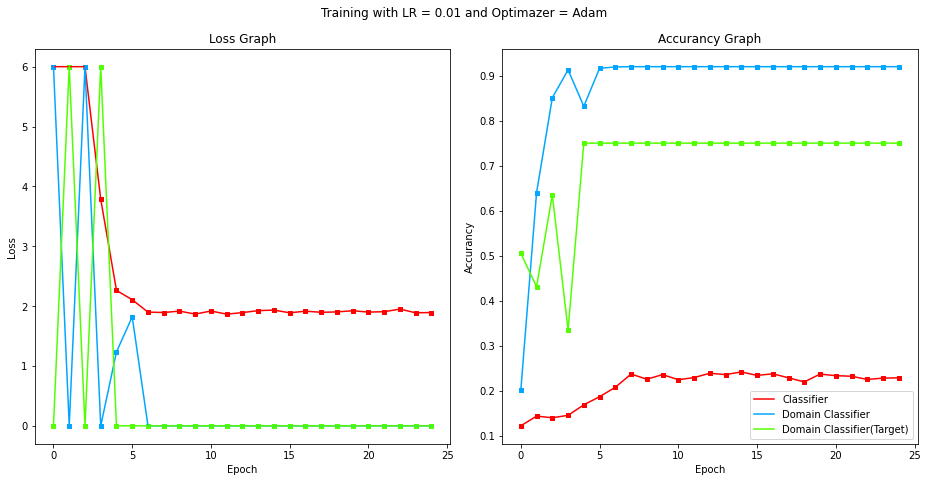

Classifier: Min Loss: 1.865606, Max Acc: 0.241916
Domain Classifier: Min Loss: 0.000000, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.000000, Max Acc: 0.750000
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = RMSprop  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/25, LR = [0.01]
Step 0, Loss Classifier: 2.31, Domain Classifier: 2.621, Domain Classifier(Target): 2.539
Starting epoch 2/25, LR = [0.01]
Step 10, Loss Classifier: 6.0, Domain Classifier: 5.697e+11, Domain Classifier(Target): 0.0
Starting epoch 3/25, LR = [0.01]
Starting epoch 4/25, LR = [0.01]
Step 20, Loss Classifier: 6.0, Domain Classifier: 2.077e+11, Domain Classifier(Target): 1.947e+13
Starting epoch 5/25, LR = [0.01]
Starting epoch 6/25, LR = [0.01]
Step 30, Loss Classifier: 6.0, Domain Classifier: 5.99e+11, Domain Classifier(Target): 7.758e+13
Starting epoch 7/25, LR = [0.01]
Step 40, Loss Classifier: 6.

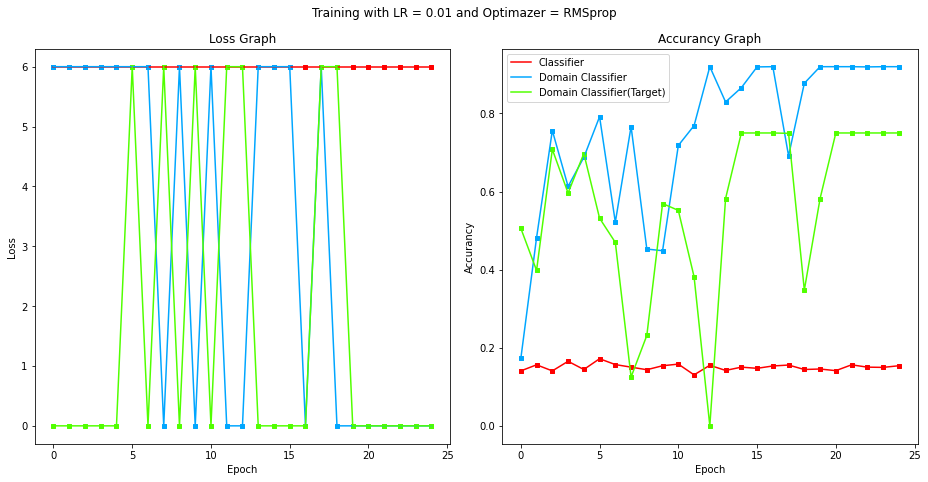

Classifier: Min Loss: 6.000000, Max Acc: 0.171856
Domain Classifier: Min Loss: 0.000000, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.000000, Max Acc: 0.750000
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = SGD  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/25, LR = [0.01]
Step 0, Loss Classifier: 2.378, Domain Classifier: 2.633, Domain Classifier(Target): 2.601
Starting epoch 2/25, LR = [0.01]
Step 10, Loss Classifier: 1.146, Domain Classifier: 0.2221, Domain Classifier(Target): 0.1503
Starting epoch 3/25, LR = [0.01]
Starting epoch 4/25, LR = [0.01]
Step 20, Loss Classifier: 0.8723, Domain Classifier: 0.09283, Domain Classifier(Target): 0.1126
Starting epoch 5/25, LR = [0.01]
Starting epoch 6/25, LR = [0.01]
Step 30, Loss Classifier: 0.7863, Domain Classifier: 0.03753, Domain Classifier(Target): 0.05136
Starting epoch 7/25, LR = [0.01]
Step 40, Loss Classifier: 0.812

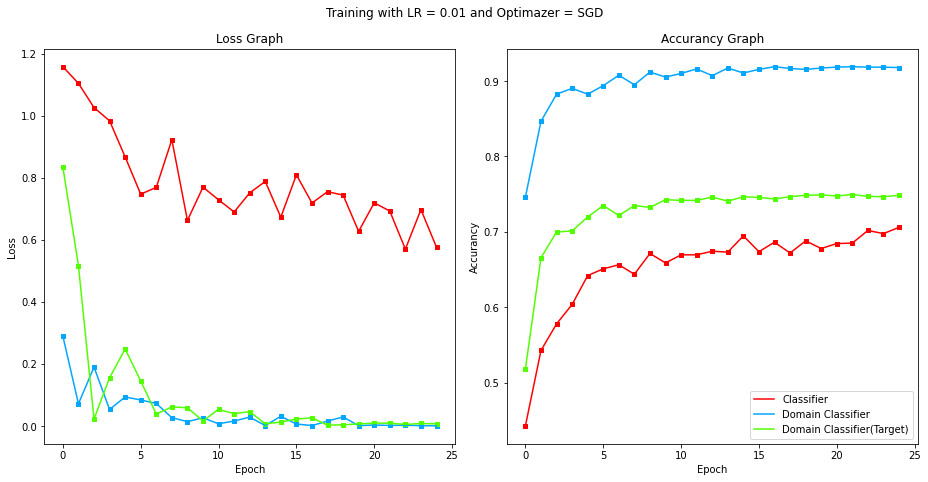

Classifier: Min Loss: 0.570384, Max Acc: 0.705988
Domain Classifier: Min Loss: 0.000885, Max Acc: 0.919162
Domain Classifier(Target): Min Loss: 0.003079, Max Acc: 0.749512
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = Adam  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/25, LR = [0.001]
Step 0, Loss Classifier: 2.662, Domain Classifier: 2.357, Domain Classifier(Target): 2.685
Starting epoch 2/25, LR = [0.001]
Step 10, Loss Classifier: 1.928, Domain Classifier: 0.4735, Domain Classifier(Target): 1.047
Starting epoch 3/25, LR = [0.001]
Starting epoch 4/25, LR = [0.001]
Step 20, Loss Classifier: 1.863, Domain Classifier: 0.6005, Domain Classifier(Target): 0.8058
Starting epoch 5/25, LR = [0.001]
Starting epoch 6/25, LR = [0.001]
Step 30, Loss Classifier: 1.882, Domain Classifier: 0.7355, Domain Classifier(Target): 0.6521
Starting epoch 7/25, LR = [0.001]
Step 40, Loss Classifier: 1.

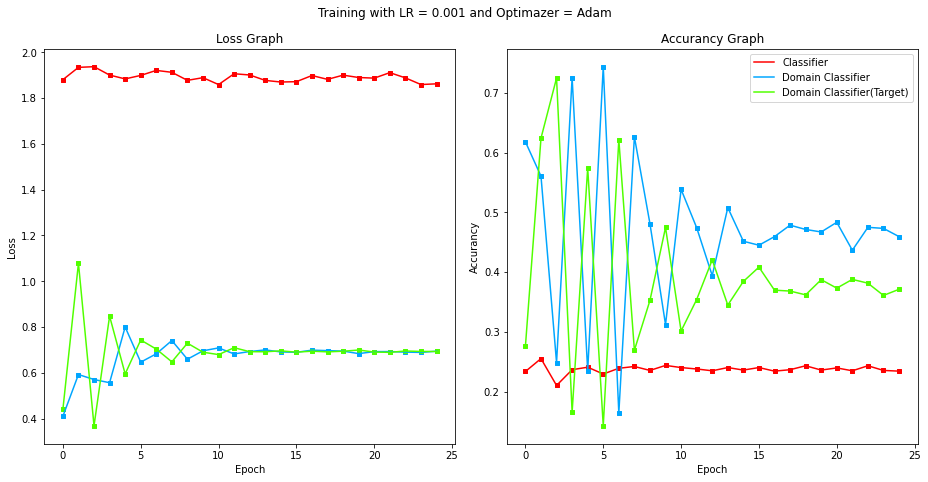

Classifier: Min Loss: 1.858608, Max Acc: 0.255090
Domain Classifier: Min Loss: 0.409942, Max Acc: 0.743713
Domain Classifier(Target): Min Loss: 0.368336, Max Acc: 0.724609
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = RMSprop  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/25, LR = [0.001]
Step 0, Loss Classifier: 2.548, Domain Classifier: 2.726, Domain Classifier(Target): 2.322
Starting epoch 2/25, LR = [0.001]
Step 10, Loss Classifier: 6.0, Domain Classifier: 0.0, Domain Classifier(Target): 6.082e+07
Starting epoch 3/25, LR = [0.001]
Starting epoch 4/25, LR = [0.001]
Step 20, Loss Classifier: 6.0, Domain Classifier: 5.42e+04, Domain Classifier(Target): 3.297e+04
Starting epoch 5/25, LR = [0.001]
Starting epoch 6/25, LR = [0.001]
Step 30, Loss Classifier: 6.0, Domain Classifier: 1.458e+08, Domain Classifier(Target): 0.0
Starting epoch 7/25, LR = [0.001]
Step 40, Loss Classifier:

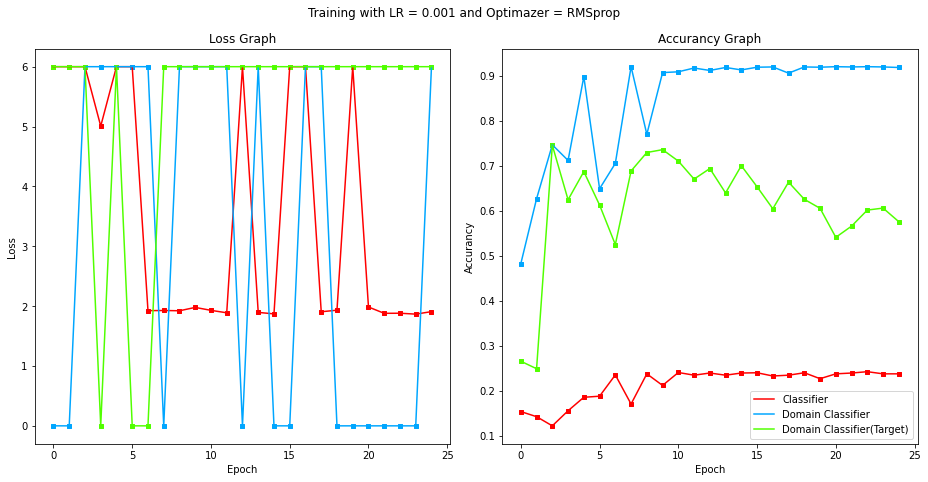

Classifier: Min Loss: 1.866235, Max Acc: 0.241916
Domain Classifier: Min Loss: 0.000000, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.000000, Max Acc: 0.745117
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = SGD  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/25, LR = [0.001]
Step 0, Loss Classifier: 2.663, Domain Classifier: 2.44, Domain Classifier(Target): 1.895
Starting epoch 2/25, LR = [0.001]
Step 10, Loss Classifier: 1.042, Domain Classifier: 0.6424, Domain Classifier(Target): 0.01815
Starting epoch 3/25, LR = [0.001]
Starting epoch 4/25, LR = [0.001]
Step 20, Loss Classifier: 1.041, Domain Classifier: 0.004339, Domain Classifier(Target): 0.3123
Starting epoch 5/25, LR = [0.001]
Starting epoch 6/25, LR = [0.001]
Step 30, Loss Classifier: 0.7074, Domain Classifier: 0.04674, Domain Classifier(Target): 0.05336
Starting epoch 7/25, LR = [0.001]
Step 40, Loss Classifie

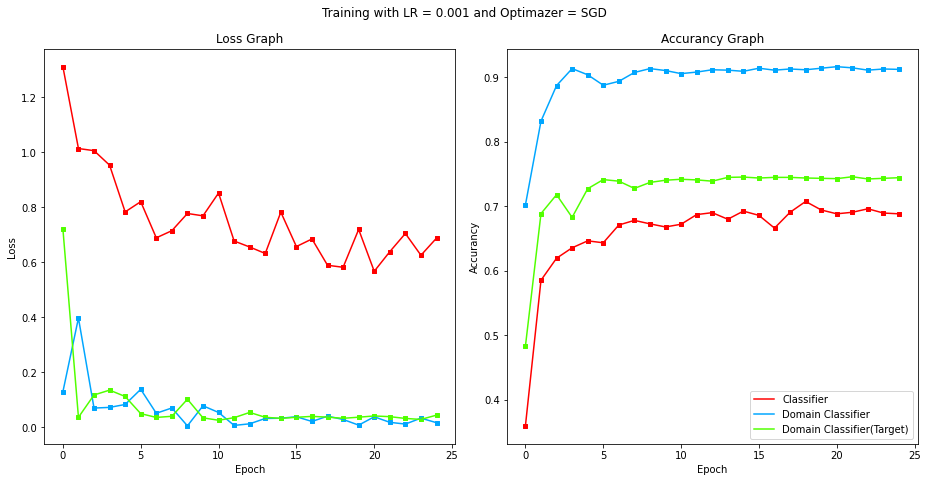

Classifier: Min Loss: 0.567192, Max Acc: 0.707784
Domain Classifier: Min Loss: 0.005332, Max Acc: 0.916766
Domain Classifier(Target): Min Loss: 0.025676, Max Acc: 0.746094
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = Adam  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/25, LR = [1e-05]
Step 0, Loss Classifier: 2.397, Domain Classifier: 2.454, Domain Classifier(Target): 1.924
Starting epoch 2/25, LR = [1e-05]
Step 10, Loss Classifier: 1.74, Domain Classifier: 0.6408, Domain Classifier(Target): 1.139
Starting epoch 3/25, LR = [1e-05]
Starting epoch 4/25, LR = [1e-05]
Step 20, Loss Classifier: 1.358, Domain Classifier: 0.2668, Domain Classifier(Target): 0.7644
Starting epoch 5/25, LR = [1e-05]
Starting epoch 6/25, LR = [1e-05]
Step 30, Loss Classifier: 1.189, Domain Classifier: 0.2721, Domain Classifier(Target): 0.5519
Starting epoch 7/25, LR = [1e-05]
Step 40, Loss Classifier: 1.1

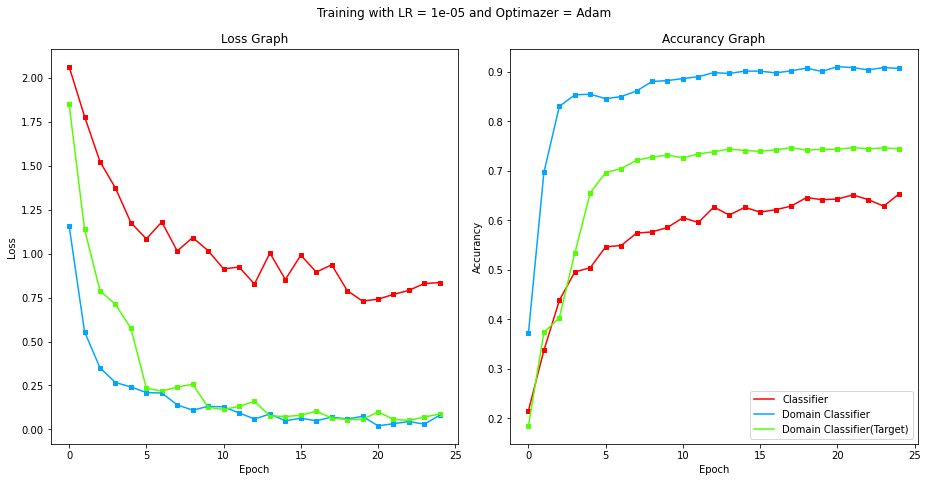

Classifier: Min Loss: 0.730108, Max Acc: 0.653892
Domain Classifier: Min Loss: 0.020414, Max Acc: 0.910778
Domain Classifier(Target): Min Loss: 0.051006, Max Acc: 0.747070
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = RMSprop  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/25, LR = [1e-05]
Step 0, Loss Classifier: 2.939, Domain Classifier: 2.862, Domain Classifier(Target): 2.063
Starting epoch 2/25, LR = [1e-05]
Step 10, Loss Classifier: 1.024, Domain Classifier: 0.01897, Domain Classifier(Target): 0.05223
Starting epoch 3/25, LR = [1e-05]
Starting epoch 4/25, LR = [1e-05]
Step 20, Loss Classifier: 0.8159, Domain Classifier: 0.01102, Domain Classifier(Target): 0.02562
Starting epoch 5/25, LR = [1e-05]
Starting epoch 6/25, LR = [1e-05]
Step 30, Loss Classifier: 0.8687, Domain Classifier: 0.05679, Domain Classifier(Target): 0.02905
Starting epoch 7/25, LR = [1e-05]
Step 40, Loss Cl

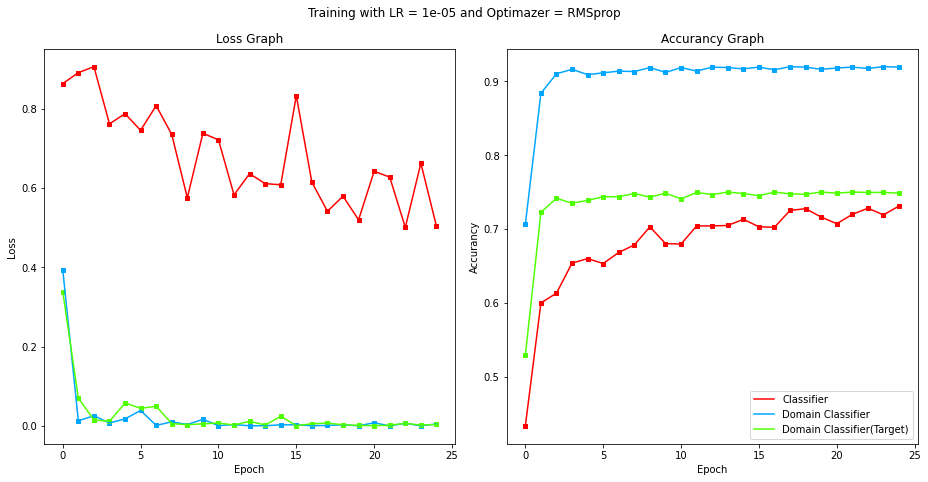

Classifier: Min Loss: 0.500660, Max Acc: 0.731138
Domain Classifier: Min Loss: 0.000095, Max Acc: 0.919760
Domain Classifier(Target): Min Loss: 0.000556, Max Acc: 0.750000
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = SGD  ---
111,595,343 total parameters.
111,595,343 training parameters.
0 freezed parameters.
1.0000 ratio training/total.

Starting epoch 1/25, LR = [1e-05]
Step 0, Loss Classifier: 2.934, Domain Classifier: 2.864, Domain Classifier(Target): 2.71
Starting epoch 2/25, LR = [1e-05]
Step 10, Loss Classifier: 2.766, Domain Classifier: 1.964, Domain Classifier(Target): 2.232
Starting epoch 3/25, LR = [1e-05]
Starting epoch 4/25, LR = [1e-05]
Step 20, Loss Classifier: 2.401, Domain Classifier: 1.017, Domain Classifier(Target): 1.765
Starting epoch 5/25, LR = [1e-05]
Starting epoch 6/25, LR = [1e-05]
Step 30, Loss Classifier: 2.178, Domain Classifier: 0.5646, Domain Classifier(Target): 1.491
Starting epoch 7/25, LR = [1e-05]
Step 40, Loss Classifier: 1.851, D

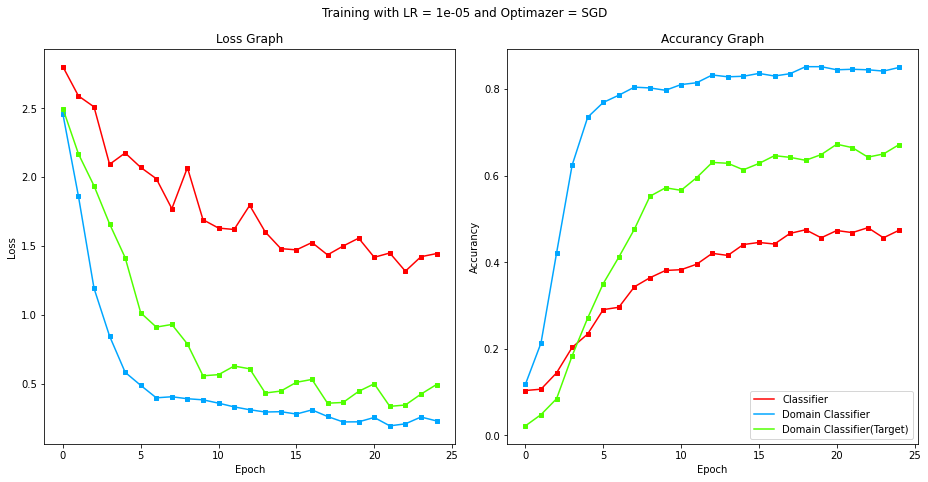

Classifier: Min Loss: 1.317790, Max Acc: 0.479641
Domain Classifier: Min Loss: 0.196835, Max Acc: 0.851497
Domain Classifier(Target): Min Loss: 0.337999, Max Acc: 0.672363
---  --- ---  ---



In [0]:
NUM_EPOCHS = 25
lr_values = [0.01, 0.001, 0.00001]
optimazers = ['Adam','RMSprop','SGD']

scores_Adap = {}
for lr in lr_values:
  for op in optimazers:

    meta = 'Training with LR = {} and Optimazer = {}'.format(lr,op)
    print('---  {}  ---'.format(meta))

    net = InitializeNet()
    print()

    criterion = nn.CrossEntropyLoss()

    parameters_to_optimize = net.parameters()
    if(op == 'Adam'):
      optimizer = optim.Adam(parameters_to_optimize, lr=lr, weight_decay=WEIGHT_DECAY)
    elif(op == 'RMSprop'):
      optimizer = optim.RMSprop(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    else:
      optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    meta_t = 'Adap lr={}, op={}'.format(lr,op)
    losses, accuracies = Training(net,True,meta=meta_t)
    PlotAccuracyLoss(losses,accuracies,meta)

    scores_Adap[(lr,op)] = (losses, accuracies)

    print('---  --- ---  ---')
    print()


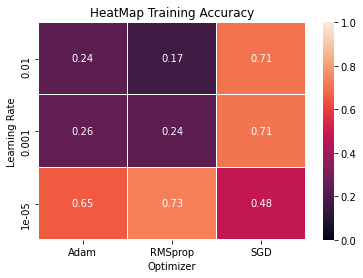

In [0]:
SketchHeatMap(scores_Adap)

In [0]:
meta_t = 'Adap lr={}, op={}'.format(0.00001,'RMSprop')
best_net = torch.load(PATH_MODELS+meta_t+'.pth')
Test(best_net)

Test Accuracy: 0.4521484375
